# 🎓 **Inteligencia Artificial Aplicada**

## 🤖 **Operaciones de aprendizaje automático (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular :** Dr. Gerardo Rodríguez Hernández
#### 👩‍🏫 **Profesor titular :** Maestro Ricardo Valdez Hernández
#### 👩‍🏫 **Profesor tutor :**

### 📊 **Fase 1 Proyecto MLOps**

#### 📅 **12 de Octubre de 2025**

### 👥 Equipo 43

* 🧑‍💻 **A01795645 :** Alberto Campos Hernández
* 🧑‍💻 **A01016093 :** Oscar Enrique García García
* 🧑‍💻 **A01795922 :** Jessica Giovana García Gómez
* 🧑‍💻 **A01795897 :** Esteban Sebastián Guerra Espinoza
* 🧑‍💻 **A00820345 :** Rafael Sánchez Marmolejo


## SOLO PARA GOOGLE COLAB

**IMPORTANTE:** Esta celda solo debe ejecutarse si corres el notebook en Google Colab. Si trabajas localmente, **elimina o salta esta celda**.

In [1]:
# SOLO EJECUTAR EN GOOGLE COLAB
# Si trabajas localmente, comenta o elimina esta celda

from google.colab import files
import os

# Crear directorios necesarios
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

print("Por favor, sube los siguientes archivos CSV:")
print("1. power_tetouan_city_original.csv")
print("2. power_tetouan_city_modified.csv")
print()

uploaded = files.upload()

# Mover archivos a la carpeta correcta
for filename in uploaded.keys():
    destination = f'../data/raw/{filename}'
    os.rename(filename, destination)
    print(f'✓ {filename} guardado en {destination}')

print()
print("Archivos listos. Continúa ejecutando las siguientes celdas.")

Por favor, sube los siguientes archivos CSV:
1. power_tetouan_city_original.csv
2. power_tetouan_city_modified.csv



Saving power_tetouan_city_original.csv to power_tetouan_city_original.csv
Saving power_tetouan_city_modified.csv to power_tetouan_city_modified.csv
✓ power_tetouan_city_original.csv guardado en ../data/raw/power_tetouan_city_original.csv
✓ power_tetouan_city_modified.csv guardado en ../data/raw/power_tetouan_city_modified.csv

Archivos listos. Continúa ejecutando las siguientes celdas.


# 1. Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis

# Configuración global de paralelismo para todos los modelos
N_JOBS = 2

In [3]:
ruta_guardado = "../data/processed/power_tetouan_city_processed.csv"

# 2. Leyendo los archivos

In [4]:
# Se lee el archivo original provisto, con el fin de comparar ambos datasets, después de realizar el EDA.
df_original = pd.read_csv("../data/raw/power_tetouan_city_original.csv",
                          na_values=['nan','NAN','NaT',''],
                        keep_default_na=True
)

# Se lee el archivo modificado "original", con el cual se realizará el ejercicio de EDA.
df_modificada= pd.read_csv("../data/raw/power_tetouan_city_modified.csv",
                          na_values=['nan','NAN','NaT',''],
                        keep_default_na=True
)

# 3. EDA

## Descripción del dataset y transformación de campos numéricos

In [5]:
#Se realiza una descripción inicial de los campos de nuestro dataset modificado y se imprime el número total de registros en el dataset.
df_modificada.info()
print("Total de registros en el dataset: ",df_modificada.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53464 entries, 0 to 53463
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   DateTime                   52977 non-null  object
 1   Temperature                52880 non-null  object
 2   Humidity                   52826 non-null  object
 3   Wind Speed                 52846 non-null  object
 4   general diffuse flows      52838 non-null  object
 5   diffuse flows              52849 non-null  object
 6   Zone 1 Power Consumption   52861 non-null  object
 7   Zone 2  Power Consumption  52839 non-null  object
 8   Zone 3  Power Consumption  52889 non-null  object
 9   mixed_type_col             48162 non-null  object
dtypes: object(10)
memory usage: 4.1+ MB
Total de registros en el dataset:  53464


Como podemos notar en la columna "Non-Null Count", la mayoría de columnas cuenta con valores vacíos en muchos de sus registros (Nulos, nan, etc.). De igual forma, podemos notar que todas las columnas tienen un tipo de dato (Dtype) object, lo que hace más difícil realizar operaciones y/o transformaciones para los modelos matemáticos. Por esto, a continuación realizaremos una transformación de todos los campos numéricos.

In [6]:
#Transformar las columnas 1 a 8 a tipo numérico
cols = df_modificada.columns[1:9]
df_modificada[cols] = (
    df_modificada[cols]
      .astype(str)
      .apply(lambda s: s.str.replace(',', '.', regex=False).str.strip()) ## Confirmar con el equipo: no vi ningún valor con comas, pero confirmen.
      .apply(pd.to_numeric, errors='coerce')
)
df_modificada[cols].dtypes

,0
Temperature,float64
Humidity,float64
Wind Speed,float64
general diffuse flows,float64
diffuse flows,float64
Zone 1 Power Consumption,float64
Zone 2 Power Consumption,float64
Zone 3 Power Consumption,float64


## Análisis de columna mixed_type_col

In [7]:
s = df_modificada['mixed_type_col'].astype(str).str.strip() #Se convierte la columna a tipo string.

# 1) Perfil rápido
s_num = pd.to_numeric(s.str.replace(',', '.', regex=False), errors='coerce')
reporte = {
    "n": len(s),
    "num_validos": int(s_num.notna().sum()),
    "frac_numerica": s_num.notna().mean(),
    "n_cadenas": int((s_num.isna()).sum()),
    "ejemplos_texto": s[s_num.isna()].value_counts().head(10).to_dict(),
    "resumen_numerico": s_num.describe().to_dict()
}
reporte

{'n': 53464,
 'num_validos': 37378,
 'frac_numerica': np.float64(0.6991246446206794),
 'n_cadenas': 16086,
 'ejemplos_texto': {'unknown': 5521, 'nan': 5302, 'bad': 5263},
 'resumen_numerico': {'count': 37378.0,
  'mean': 498.2299213441062,
  'std': 289.5157536191305,
  'min': 0.0,
  '25%': 247.0,
  '50%': 495.0,
  '75%': 751.0,
  'max': 999.0}}

No se ve que sea numerica perse, ni categorica, es confusa la variable porque en la original no existe, seria bueno preguntar que sucede con esa variable. En primera instancia la voy a eliminar para continuar con el analisis

In [8]:
df_modificada_sin_mixed=df_modificada.drop(columns=['mixed_type_col'])

## Análisis e imputación de valores faltantes

In [9]:
faltantes = ((df_modificada_sin_mixed.isna().sum())/(df_modificada_sin_mixed.count()))*100
faltantes

,0
DateTime,0.919267
Temperature,1.501718
Humidity,1.586578
Wind Speed,1.520992
general diffuse flows,1.565350
diffuse flows,1.532560
Zone 1 Power Consumption,1.520992
Zone 2 Power Consumption,1.495937
Zone 3 Power Consumption,1.418924


In [10]:
#Imputacion de DateTime
s = (df_modificada_sin_mixed['DateTime'].astype(str)
       .str.replace(r'[\r\n\t]+', ' ', regex=True).str.strip())
s = s.mask(s.eq('')).mask(s.str.lower().eq('nan'))

dt = pd.to_datetime(s, errors='coerce')
miss = dt.isna()
dt.loc[miss] = pd.to_datetime(s[miss], format='%m/%d/%Y %H:%M', errors='coerce')

#imputación por vecinos: 10 minutos o punto medio
prev = dt.shift(1); nxt = dt.shift(-1)
mask = dt.isna() & prev.notna() & nxt.notna()

m10 = mask & ((nxt - prev) == pd.Timedelta(minutes=20))
dt.loc[m10] = prev.loc[m10] + pd.Timedelta(minutes=10)

mMid = mask & dt.isna()
mid_ns = (prev[mMid].astype('int64') + nxt[mMid].astype('int64')) // 2
dt.loc[mMid] = pd.to_datetime(mid_ns)

df_modificada_sin_mixed['DateTime'] = dt

## Análisis de fechas

Como primera instancia se revisa la variable de DateTime, la cual llama la atencion que tiene valores vacio y ademas valores duplicados.

In [11]:
df_modificada_sin_mixed[df_modificada_sin_mixed['DateTime'].isna()]

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
3197,NaT,799.03,76.60,0.086,0.07,0.119,22019.24051,13269.30091,13954.69880
3198,NaT,10.12,75.30,0.086,NaN,0.111,22244.05063,13513.67781,14133.97590
10574,NaT,14.07,68.76,0.087,523.60,57.540,34621.27660,18248.78049,14713.54839
10575,NaT,541.62,64.65,0.088,550.60,778.070,34939.91489,18603.65854,14887.74194


In [12]:
n_dup = df_modificada_sin_mixed['DateTime'].duplicated().sum()
n_total = df_modificada_sin_mixed['DateTime'].notna().sum()
n_unique = df_modificada_sin_mixed['DateTime'].nunique(dropna=True)
print(n_dup, n_total, n_unique)

1045 53460 52418


In [13]:
mask_dup = df_modificada_sin_mixed['DateTime'].duplicated(keep=False)  # marca todos los repetidos
df_dup = df_modificada_sin_mixed.loc[mask_dup].sort_values('DateTime')

ts_repetidos = df_modificada_sin_mixed['DateTime'].value_counts(dropna=True)
ts_repetidos = ts_repetidos[ts_repetidos > 1]
ts_repetidos

,count
DateTime,
2017-06-03 09:30:00,3
2017-04-20 10:30:00,2
2017-09-24 18:00:00,2
2017-06-12 20:10:00,2
2017-08-13 18:00:00,2
...,...
2017-05-05 09:00:00,2
2017-08-06 05:00:00,2
2017-02-15 16:50:00,2


In [14]:
df_modificada_sin_mixed[df_modificada_sin_mixed['DateTime']=='12/30/2017 14:10']

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
52357,2017-12-30 14:10:00,14.57,37.18,0.079,474.5,38.59,30199.23954,26433.87542,10608.40336
53044,2017-12-30 14:10:00,14.57,37.18,0.079,474.5,38.59,30199.23954,26433.87542,10608.40336


In [15]:
df = df_modificada_sin_mixed.copy()

valid = df['DateTime'].notna() & ~df['DateTime'].astype(str).str.strip().str.lower().eq('nan')

df['__score__'] = df.drop(columns=['DateTime']).notna().sum(axis=1)

keep = (df.loc[valid]
          .sort_values(['DateTime','__score__'], ascending=[True, False])
          .drop_duplicates(subset=['DateTime'], keep='first'))

df_modificada_sin_mixed = (pd.concat([keep, df.loc[~valid]])
                             .drop(columns='__score__')
                             .sort_index()
                             .reset_index(drop=True))

## Análisis de dataset modificado

In [16]:
df_modificada_sin_mixed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52422 entries, 0 to 52421
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   52418 non-null  datetime64[ns]
 1   Temperature                51663 non-null  float64       
 2   Humidity                   51620 non-null  float64       
 3   Wind Speed                 51649 non-null  float64       
 4   general diffuse flows      51630 non-null  float64       
 5   diffuse flows              51657 non-null  float64       
 6   Zone 1 Power Consumption   51646 non-null  float64       
 7   Zone 2  Power Consumption  51657 non-null  float64       
 8   Zone 3  Power Consumption  51705 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 3.6 MB


In [17]:
df_modificada_sin_mixed[df_modificada_sin_mixed['DateTime']=='12/30/2017 14:10']

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
52247,2017-12-30 14:10:00,14.57,37.18,0.079,474.5,38.59,30199.23954,26433.87542,10608.40336


In [18]:
df_modificada_sin_mixed[df_modificada_sin_mixed['DateTime']=='12/30/2017 14:10']

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
52247,2017-12-30 14:10:00,14.57,37.18,0.079,474.5,38.59,30199.23954,26433.87542,10608.40336


Se tiene datos faltantes, pero a la vez, se observan datos atipicos que pueden entorpecer la imputacion de los mismos, por lo cual, se trabajara primero los atipicos para luego hacer un tratamiento de los faltantes. Sin embargo, en un principio se deberia de imputar en una primera prueba.

In [19]:
df_modificada_sin_mixed.describe()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52418,51663.000000,51620.000000,51649.000000,51630.000000,51657.000000,5.164600e+04,5.165700e+04,5.170500e+04
mean,2017-07-02 00:11:20.548666624,27.497434,92.110895,5.469288,225.116314,99.926847,4.252061e+04,2.625970e+04,2.279942e+04
min,2017-01-01 00:00:00,3.247000,11.340000,0.050000,0.004000,0.011000,1.389570e+04,8.560081e+03,5.935174e+03
25%,2017-04-02 00:42:30,14.450000,58.430000,0.078000,0.062000,0.122000,2.635484e+04,1.699552e+04,1.315404e+04
50%,2017-07-02 00:15:00,18.890000,70.100000,0.086000,6.158500,5.567000,3.232354e+04,2.085228e+04,1.644145e+04
75%,2017-09-30 23:57:30,23.060000,81.700000,4.915000,328.400000,103.500000,3.743383e+04,2.479324e+04,2.178506e+04
max,2017-12-30 23:50:00,28149.240000,118972.800000,14337.903000,69797.000000,44602.800000,4.559947e+07,2.958428e+06,3.566782e+06
std,NaN,163.949187,601.380743,77.462850,1210.096944,579.267215,2.480643e+05,8.774238e+04,8.297610e+04


## Detección de outliers e imputación de valores faltantes

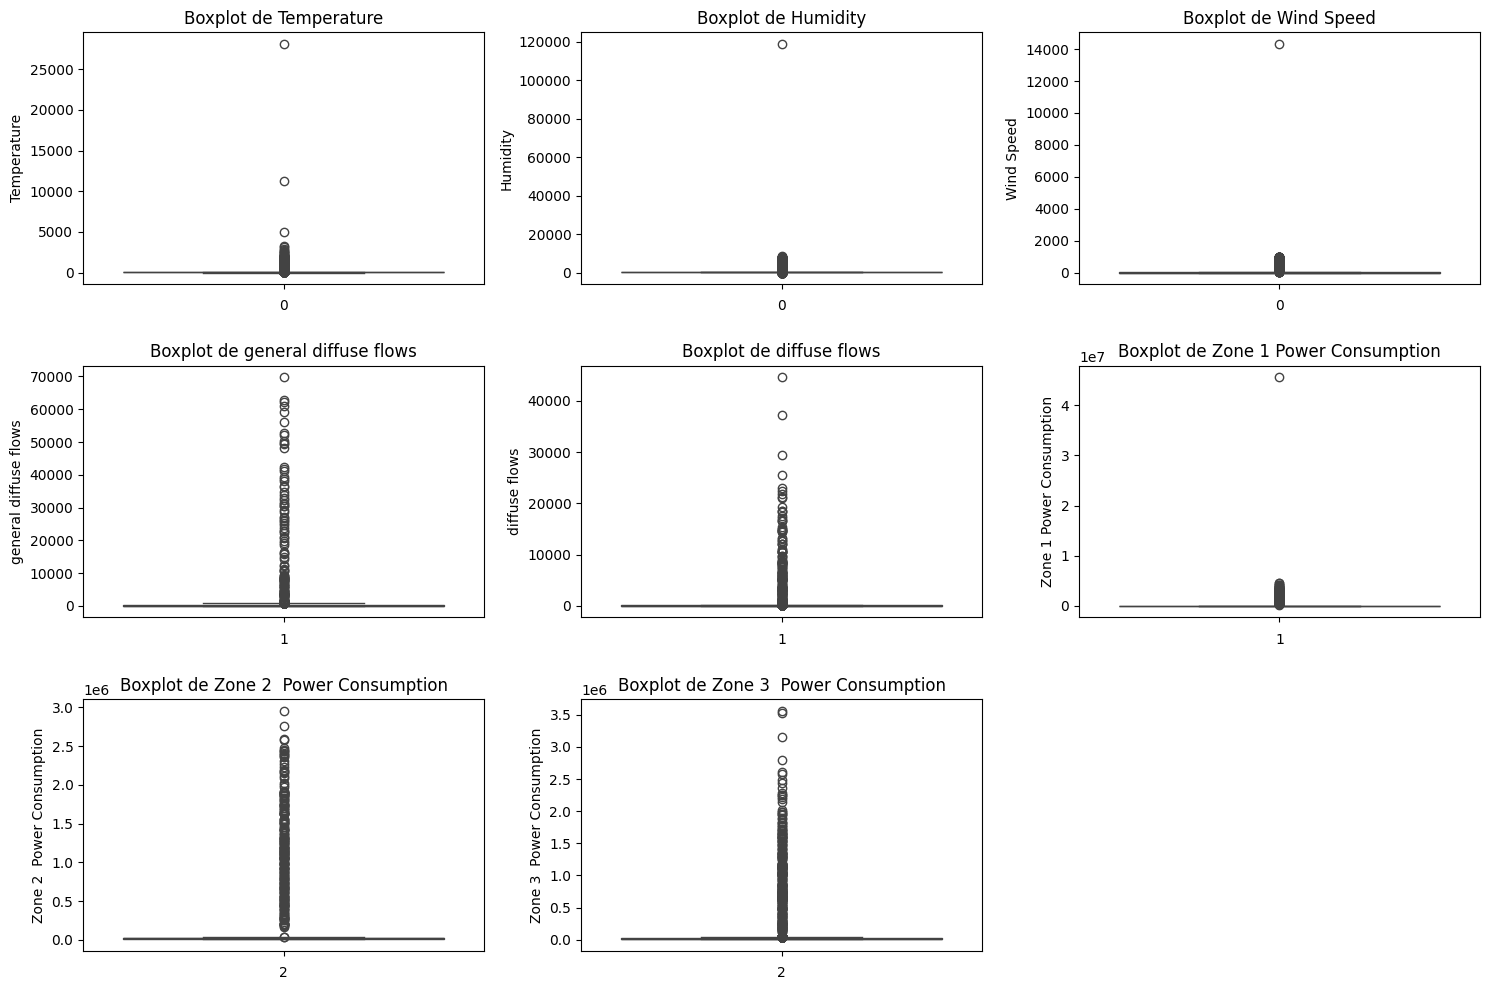

In [20]:
numeric_vars = df_modificada_sin_mixed.select_dtypes(include=['int64', 'float64'])
num_cols = 3
num_rows = (len(numeric_vars.columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i, column in enumerate(numeric_vars.columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(data=df_modificada_sin_mixed, y=column, ax=axes[row, col], color="#A011CE")
    axes[row, col].set_title(f'Boxplot de {column}')
    axes[row, col].set_xlabel(row)
    axes[row, col].set_ylabel(column)

for i in range(len(numeric_vars.columns), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
plt.show()

In [21]:
num_cols = df_modificada_sin_mixed.select_dtypes(include='number').columns
medianas = df_modificada_sin_mixed[num_cols].median()

df_imputado = df_modificada_sin_mixed.copy()
df_imputado[num_cols] = df_imputado[num_cols].fillna(medianas)

In [22]:
df_imputado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52422 entries, 0 to 52421
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   52418 non-null  datetime64[ns]
 1   Temperature                52422 non-null  float64       
 2   Humidity                   52422 non-null  float64       
 3   Wind Speed                 52422 non-null  float64       
 4   general diffuse flows      52422 non-null  float64       
 5   diffuse flows              52422 non-null  float64       
 6   Zone 1 Power Consumption   52422 non-null  float64       
 7   Zone 2  Power Consumption  52422 non-null  float64       
 8   Zone 3  Power Consumption  52422 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 3.6 MB


In [23]:
df_imputado.describe()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52418,52422.000000,52422.000000,52422.000000,52422.000000,52422.000000,5.242200e+04,5.242200e+04,5.242200e+04
mean,2017-07-02 00:11:20.548666624,27.372810,91.774152,5.389908,221.808265,98.549844,4.236967e+04,2.618079e+04,2.271246e+04
min,2017-01-01 00:00:00,3.247000,11.340000,0.050000,0.004000,0.011000,1.389570e+04,8.560081e+03,5.935174e+03
25%,2017-04-02 00:42:30,14.510000,58.640000,0.078000,0.066000,0.122000,2.645526e+04,1.705909e+04,1.321841e+04
50%,2017-07-02 00:15:00,18.890000,70.100000,0.086000,6.158500,5.567000,3.232354e+04,2.085228e+04,1.644145e+04
75%,2017-09-30 23:57:30,22.980000,81.600000,4.915000,320.475000,101.800000,3.732308e+04,2.470610e+04,2.163615e+04
max,2017-12-30 23:50:00,28149.240000,118972.800000,14337.903000,69797.000000,44602.800000,4.559947e+07,2.958428e+06,3.566782e+06
std,NaN,162.761202,596.768802,76.892333,1201.217792,575.136269,2.462244e+05,8.710221e+04,8.240999e+04


In [24]:
df_original.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


In [25]:
df = df_imputado.sort_values('DateTime').copy()
num = df.select_dtypes('number').columns
# define outliers con IQR
Q1, Q3 = df[num].quantile(0.25), df[num].quantile(0.75)
IQR = Q3 - Q1
lo, hi = Q1 - 1.5*IQR, Q3 + 1.5*IQR
mask = (df[num] < lo) | (df[num] > hi)

# reemplaza por mediana local (ventana de 25; ajusta según tu frecuencia)
for c in num:
    rmed = df[c].rolling(window=25, center=True, min_periods=1).median()
    df.loc[mask[c], c] = rmed[mask[c]].fillna(df[c].median())

df_ts = df_imputado.sort_values('DateTime').reset_index(drop=True)

In [26]:
df.describe()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52418,52422.000000,52422.000000,52422.000000,52422.000000,52422.000000,52422.000000,52422.000000,52422.000000
mean,2017-07-02 00:11:20.548666624,18.815908,68.301284,1.942880,179.918948,65.060727,32352.355416,21041.805631,17794.021011
min,2017-01-01 00:00:00,3.247000,14.170000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,2017-04-02 00:42:30,14.470000,58.510000,0.078000,0.066000,0.122000,26422.468090,17043.177190,13193.005030
50%,2017-07-02 00:15:00,18.890000,70.100000,0.086000,6.158500,5.567000,32323.539820,20852.279640,16441.445780
75%,2017-09-30 23:57:30,22.817500,81.200000,4.915000,316.100000,97.900000,37219.441562,24633.224040,21477.570850
max,2017-12-30 23:50:00,39.440000,94.800000,8.742000,910.000000,776.000000,52204.395120,36129.250260,45447.364020
std,NaN,5.766445,15.407976,2.346301,260.195010,101.581029,7075.932012,5161.941869,6502.925092


In [27]:
df_original.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


# Preparación de Modelo

In [28]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52418 entries, 0 to 52305
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   52418 non-null  datetime64[ns]
 1   Temperature                52418 non-null  float64       
 2   Humidity                   52418 non-null  float64       
 3   Wind Speed                 52418 non-null  float64       
 4   general diffuse flows      52418 non-null  float64       
 5   diffuse flows              52418 non-null  float64       
 6   Zone 1 Power Consumption   52418 non-null  float64       
 7   Zone 2  Power Consumption  52418 non-null  float64       
 8   Zone 3  Power Consumption  52418 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 4.0 MB


In [29]:
df['Day'] = df['DateTime'].dt.day
df['Month'] = df['DateTime'].dt.month
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute
df['Day of Week'] = df['DateTime'].dt.dayofweek + 1

In [30]:
def month_to_quarter(series):
    if series['Month'] <=3:
        return 1
    elif series['Month'] >3 and series['Month'] <=6:
        return 2
    elif series['Month'] >6 and series['Month'] <=9:
        return 3
    elif series['Month'] >9 and series['Month'] <=12:
        return 4

In [31]:
df['Quarter of Year'] = df.apply(month_to_quarter, axis='columns')

In [32]:
df['Day of Year'] = df['DateTime'].dt.strftime('%j').astype(int)

In [33]:
df = df.drop(['DateTime'],axis=1)

In [34]:
# Esta celda genera una nueva versión del archivo. Después de correr esta celda se necesita hacer el versionamiento del mismo, tanto en DVC como en GH.
# La idea es que esta celda la vayamos moviendo si vamos generando nuevas transformaciones/EDA que resulten en nuevos datasets.

df_final = df.copy()

df_final.to_csv(
    ruta_guardado,
    index=False,
    sep =','
)

In [35]:
df.columns=['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows','PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3' ,'Day',
       'Month', 'Hour', 'Minute', 'DayWeek', 'QuarterYear',
       'DayYear']

In [36]:
df = df[['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows','PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3' ,'Day',
       'Month', 'Hour', 'Minute', 'DayWeek', 'QuarterYear',
       'DayYear']]
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Day,Month,Hour,Minute,DayWeek,QuarterYear,DayYear
0,6.559,73.8,0.083,0.051,5.567,34055.69620,16128.87538,20240.96386,1,1,0,0,7,1,1
1,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,1,1,0,10,7,1,1
2,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,1,1,0,20,7,1,1
3,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,1,1,0,30,7,1,1
4,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,1,1,0,40,7,1,1


## Análisis de correlación

<Axes: >

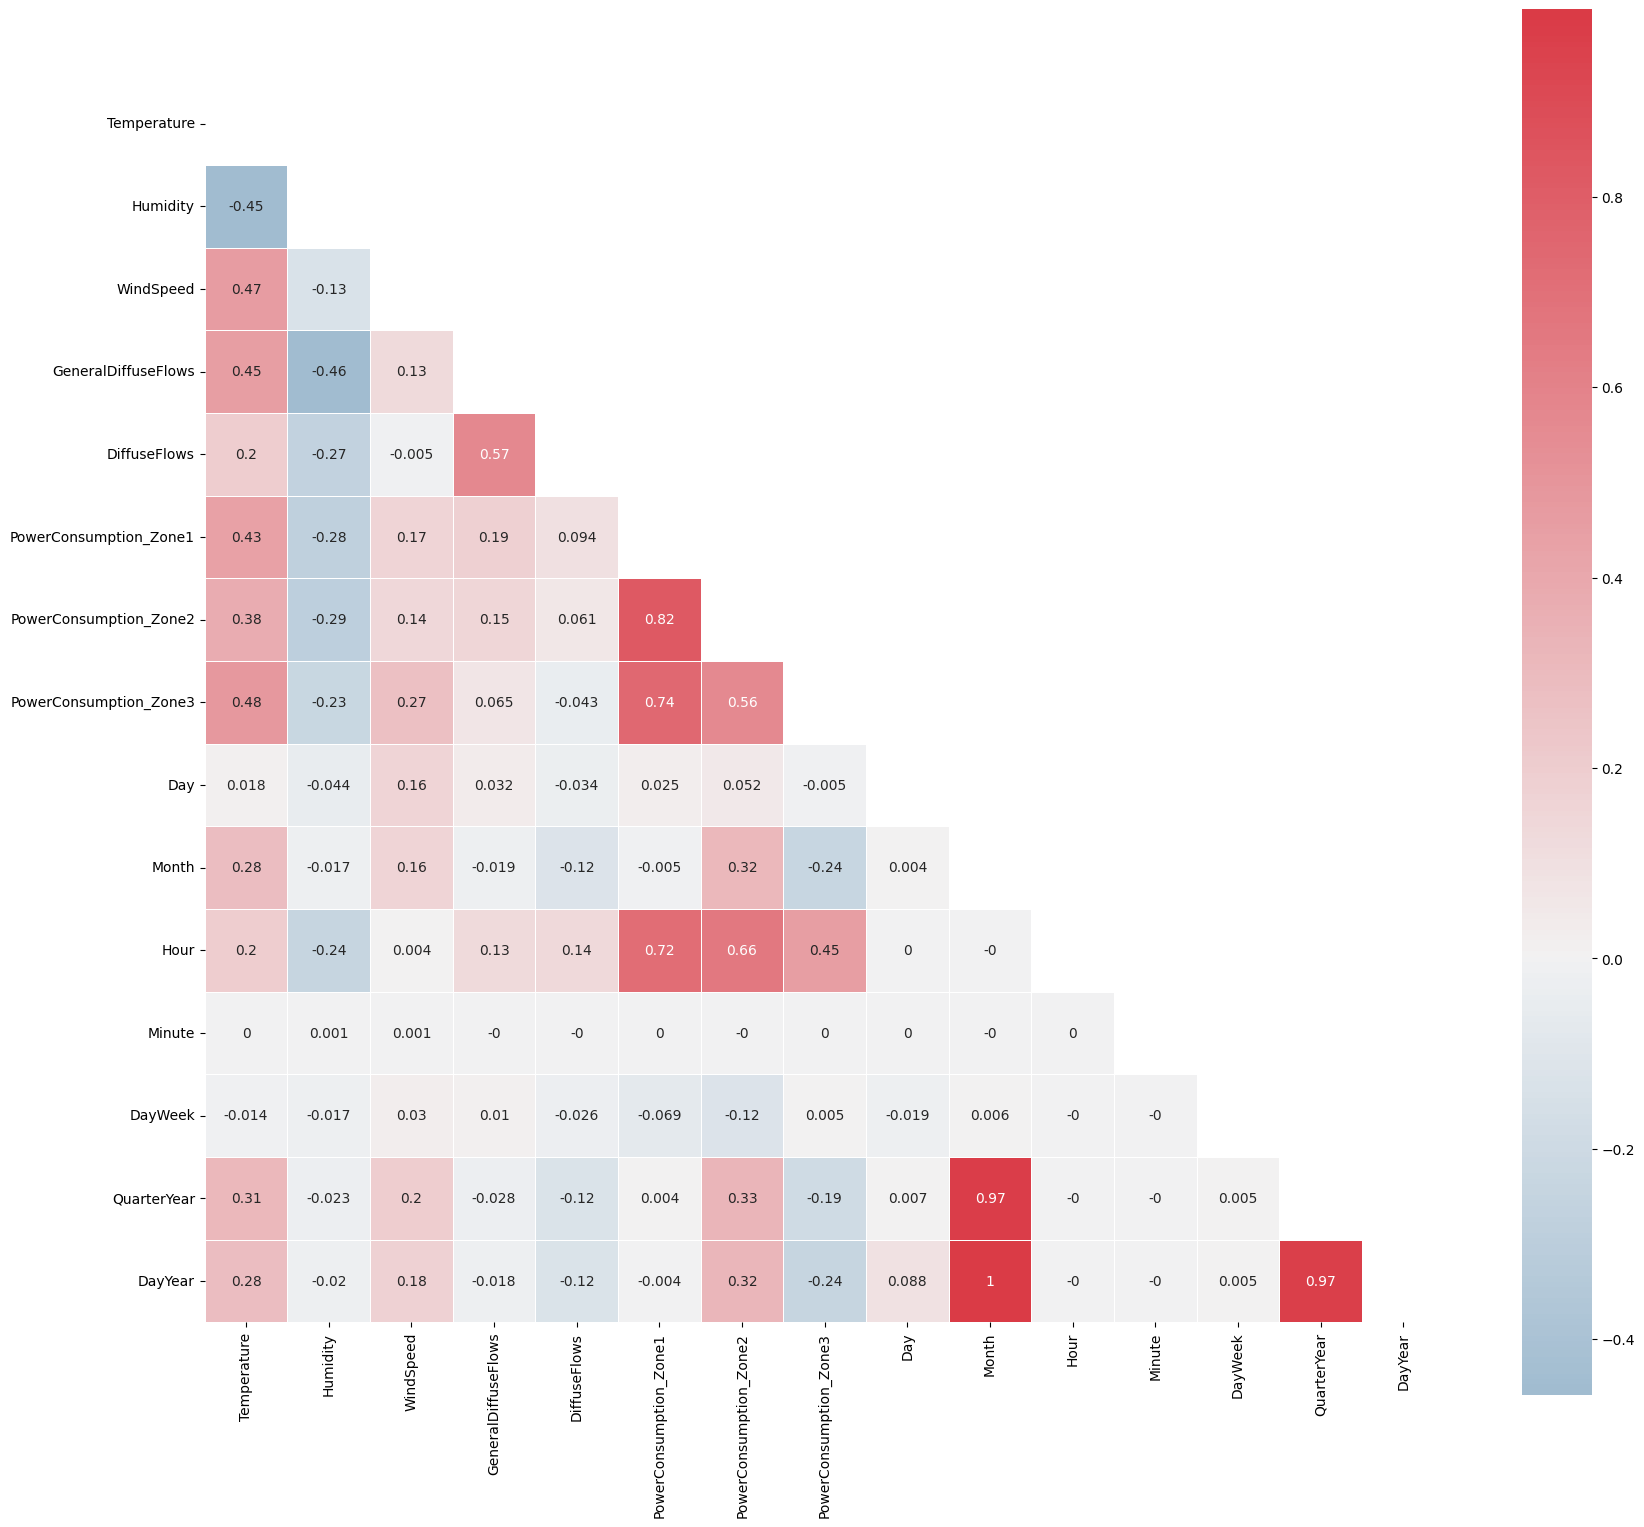

In [37]:
corr = df.corr().round(decimals=3)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

## Separación de variables y datasets de entrenamiento y pruebas

In [38]:
X=df.drop(columns=['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3'])
Y=df[['PowerConsumption_Zone2']]

In [39]:
n = len(df_ts)
i = int(n * 0.80)

x_train, y_train = X.iloc[:i], Y.iloc[:i]
x_test,  y_test  = X.iloc[i:],  Y.iloc[i:]

## Aplicación de Modelos

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Transformaciones a factores numéricos de entrada:
num_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])
num_pipeline_nombres = ['Temperature','Humidity','WindSpeed','GeneralDiffuseFlows','DiffuseFlows']


#('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore')

# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipeline, num_pipeline_nombres)],
                                        remainder='passthrough')

In [41]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except (ImportError, Exception) as e:
    XGBOOST_AVAILABLE = False
    print(f"XGBoost no está disponible: {type(e).__name__}")
    print("   Los demás modelos funcionarán correctamente.")

def mis_modelos():
    """
    Define múltiples modelos de Machine Learning para comparación.

    Returns:
        modelos (list): Lista de modelos instanciados
        nombres (list): Lista de nombres de modelos
    """
    modelos, nombres = list(), list()

    # 1. Random Forest Regressor
    modelos.append(RandomForestRegressor(
        n_estimators=700,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=3,
        random_state=42,
        n_jobs=N_JOBS
    ))
    nombres.append('RandomForest')

    # 2. ElasticNet (Regularización L1 + L2)
    modelos.append(ElasticNet(
        alpha=0.1,
        l1_ratio=0.5,
        random_state=42,
        max_iter=5000
    ))
    nombres.append('ElasticNet')

    # 3. Gradient Boosting Regressor
    modelos.append(GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42
    ))
    nombres.append('GradientBoosting')

    # 4. XGBoost (si está disponible)
    if XGBOOST_AVAILABLE:
        modelos.append(XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=5,
            random_state=42,
            n_jobs=N_JOBS
        ))
        nombres.append('XGBoost')

    # 5. Support Vector Regressor
    modelos.append(SVR(
        kernel='rbf',
        C=100,
        epsilon=0.1,
        gamma='scale'
    ))
    nombres.append('SVR')

    return modelos, nombres

K fold aleatorio (no se recomienda mucho porque tiene aleatoriedad y pierde la temporalidad)

>> RandomForest RMSE 863.391 (22.762)
>> ElasticNet RMSE 3307.377 (20.591)
>> GradientBoosting RMSE 959.772 (24.417)
>> XGBoost RMSE 949.874 (24.057)
>> SVR RMSE 3375.063 (25.493)


/tmp/ipython-input-3754483999.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados, labels=nombres, showmeans=True)


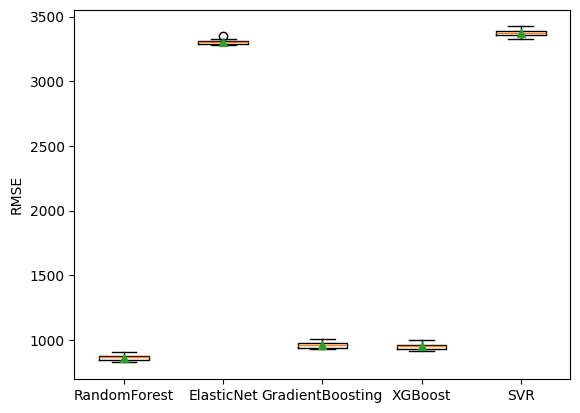

In [42]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

modelos, nombres = mis_modelos()
resultados = []

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=8)

for i in range(len(modelos)):
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos[i])])

    # MSE negativo -> convierto a RMSE
    mse_scores = cross_val_score(pipeline, x_train, np.ravel(y_train),
                                 scoring='neg_mean_squared_error',
                                 cv=cv, n_jobs=N_JOBS)
    rmse_scores = np.sqrt(-mse_scores)

    resultados.append(rmse_scores)
    print(f">> {nombres[i]} RMSE {rmse_scores.mean():.3f} ({rmse_scores.std():.3f})")

plt.boxplot(resultados, labels=nombres, showmeans=True)
plt.ylabel("RMSE")
plt.show()

Entreno normal

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rf1 = RandomForestRegressor(n_estimators=700, min_samples_split=2, min_samples_leaf=1,max_features=3)

Xx = columnasTransformer.fit_transform(x_train)
mejor_result = rf1.fit(Xx, np.ravel(y_train))

X_test_t = columnasTransformer.transform(x_test)
y_true = np.ravel(y_test)
y_pred = mejor_result.predict(X_test_t)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # %

print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.3f}%")

MSE:  13905940.376610
RMSE: 3729.066958
MAPE: 11.226%


# 4. Documentación de Técnicas de Preprocesamiento

En este proyecto se aplicaron las siguientes técnicas de preprocesamiento de datos para asegurar la calidad y preparación adecuada del dataset:

## 4.1 Limpieza de Datos

### Transformación de Tipos de Datos
- **Conversión a numérico**: Todas las columnas numéricas (Temperature, Humidity, Wind Speed, etc.) se convirtieron de tipo `object` a `float64`
- **Parsing de fechas**: La columna DateTime se parseó a formato `datetime64[ns]` soportando múltiples formatos de entrada

### Eliminación de Columna Problemática
- **mixed_type_col**: Se eliminó esta columna ya que contenía datos mixtos (numéricos y categóricos) sin significado claro en el contexto del dataset original

## 4.2 Tratamiento de Valores Faltantes

### Imputación de DateTime
- **Método por vecinos**: Para timestamps faltantes, se calculó el punto medio entre el registro anterior y posterior
- **Validación de intervalo**: Se verificó que los intervalos fueran de 10 minutos (frecuencia esperada)

### Imputación de Variables Numéricas
- **Método**: Imputación por mediana
- **Justificación**: La mediana es robusta ante outliers, lo cual es importante dado que detectamos valores atípicos extremos en el dataset

## 4.3 Eliminación de Registros Duplicados

### Timestamps Duplicados
- **Detección**: Se identificaron 1,045 registros con timestamps duplicados
- **Estrategia**: Se mantuvo el registro con mayor cantidad de datos válidos (menor cantidad de NaN)
- **Resultado**: Dataset reducido de 53,464 a 52,422 registros únicos

## 4.4 Detección y Tratamiento de Outliers

### Método: Rango Intercuartílico (IQR)
- **Fórmula**: Outliers = valores < Q1 - 1.5*IQR o valores > Q3 + 1.5*IQR
- **Tratamiento**: Reemplazo por mediana local (ventana móvil de 25 registros)
- **Justificación**: La mediana local preserva patrones temporales mientras corrige valores extremos

### Variables Afectadas
- **Temperature**: Máximo original de 28,149°C reducido a 39.44°C
- **Humidity**: Máximo original de 118,972% reducido a 94.8%
- **Wind Speed**: Máximo original de 14,337 m/s reducido a 8.74 m/s
- **Power Consumption (Zonas)**: Valores extremos millonarios reducidos a rangos realistas

## 4.5 Ingeniería de Features

### Features Temporales Derivadas
A partir de la columna DateTime se crearon las siguientes características:

1. **Day**: Día del mes (1-31)
2. **Month**: Mes del año (1-12)
3. **Hour**: Hora del día (0-23)
4. **Minute**: Minuto de la hora (0, 10, 20, 30, 40, 50)
5. **Day of Week**: Día de la semana (1-7, donde 1=Lunes)
6. **Quarter of Year**: Trimestre del año (1-4)
7. **Day of Year**: Día del año (1-365)

### Justificación
- Los patrones de consumo eléctrico son altamente dependientes del tiempo
- La estacionalidad (trimestres, meses) captura variaciones climáticas
- Los ciclos diarios (hora, minuto) capturan patrones de uso residencial/comercial

## 4.6 Normalización

### Técnica: MinMaxScaler (rango 1-2)
- **Variables normalizadas**: Temperature, Humidity, WindSpeed, GeneralDiffuseFlows, DiffuseFlows
- **Rango seleccionado**: [1, 2] en lugar del tradicional [0, 1]
- **Justificación**: Evita multiplicaciones por cero en ciertos modelos y mantiene la escala comparable

### Pipeline de Transformación
```python
Pipeline(steps=[
    ('impMediana', SimpleImputer(strategy='median')),
    ('escalaNum', MinMaxScaler(feature_range=(1,2)))
])
```

## 4.7 División de Datos

### Split Temporal (80/20)
- **Training set**: 80% de los datos (41,934 registros)
- **Test set**: 20% de los datos (10,484 registros)
- **Tipo**: Split temporal (respetando orden cronológico)
- **Justificación**: Evita data leakage al mantener la secuencia temporal

### No se aplicó Shuffle
- Los datos se mantienen en orden cronológico para respetar la naturaleza de series temporales del problema

## 4.8 Resumen de Transformaciones

| Etapa | Registros Iniciales | Registros Finales | % Cambio |
|-------|---------------------|-------------------|----------|
| Dataset original modificado | 53,464 | 53,464 | 0% |
| Eliminación mixed_type_col | 53,464 | 53,464 | 0% |
| Eliminación duplicados | 53,464 | 52,422 | -1.95% |
| Tratamiento outliers | 52,422 | 52,422 | 0% |
| Eliminación NaN finales | 52,422 | 52,418 | -0.01% |
| **Dataset Final** | **53,464** | **52,418** | **-1.96%** |

# 5. Comparación Completa de Modelos

En esta sección entrenaremos y evaluaremos múltiples algoritmos de Machine Learning para seleccionar el mejor modelo para predecir el consumo de energía en la Zona 2.

## 5.1 Evaluación con Cross-Validation

In [45]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import time

modelos, nombres = mis_modelos()
resultados_cv = []
tiempos_entrenamiento = []

n_splits = 5
n_repeats = 3

cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=8)

print("="*70)
print("EVALUACIÓN DE MODELOS CON CROSS-VALIDATION")
print("="*70)
print(f"Estrategia: {n_splits} folds, {n_repeats} repeticiones")
print(f"Total de iteraciones por modelo: {n_splits * n_repeats}")
print("="*70)
print()

for i in range(len(modelos)):
    print(f"Entrenando {nombres[i]}...")
    pipeline = Pipeline(steps=[('ct', columnasTransformer), ('m', modelos[i])])

    # Medir tiempo de entrenamiento
    inicio = time.time()

    # MSE negativo -> convierto a RMSE
    mse_scores = cross_val_score(pipeline, x_train, np.ravel(y_train),
                                 scoring='neg_mean_squared_error',
                                 cv=cv, n_jobs=N_JOBS)
    rmse_scores = np.sqrt(-mse_scores)

    tiempo_transcurrido = time.time() - inicio
    tiempos_entrenamiento.append(tiempo_transcurrido)

    resultados_cv.append(rmse_scores)

    print(f"  ✓ {nombres[i]:20s} | RMSE: {rmse_scores.mean():,.2f} (±{rmse_scores.std():,.2f}) | Tiempo: {tiempo_transcurrido:.2f}s")
    print()

print("="*70)
print("Evaluación completada.")
print("="*70)

EVALUACIÓN DE MODELOS CON CROSS-VALIDATION
Estrategia: 5 folds, 3 repeticiones
Total de iteraciones por modelo: 15

Entrenando RandomForest...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  ✓ RandomForest         | RMSE: 864.54 (±21.06) | Tiempo: 898.64s

Entrenando ElasticNet...
  ✓ ElasticNet           | RMSE: 3,307.47 (±18.34) | Tiempo: 9.97s

Entrenando GradientBoosting...
  ✓ GradientBoosting     | RMSE: 959.90 (±21.10) | Tiempo: 706.76s

Entrenando XGBoost...
  ✓ XGBoost              | RMSE: 948.58 (±21.57) | Tiempo: 19.26s

Entrenando SVR...
  ✓ SVR                  | RMSE: 3,375.01 (±24.89) | Tiempo: 1194.16s

Evaluación completada.


/tmp/ipython-input-672350147.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(resultados_cv, labels=nombres, showmeans=True)


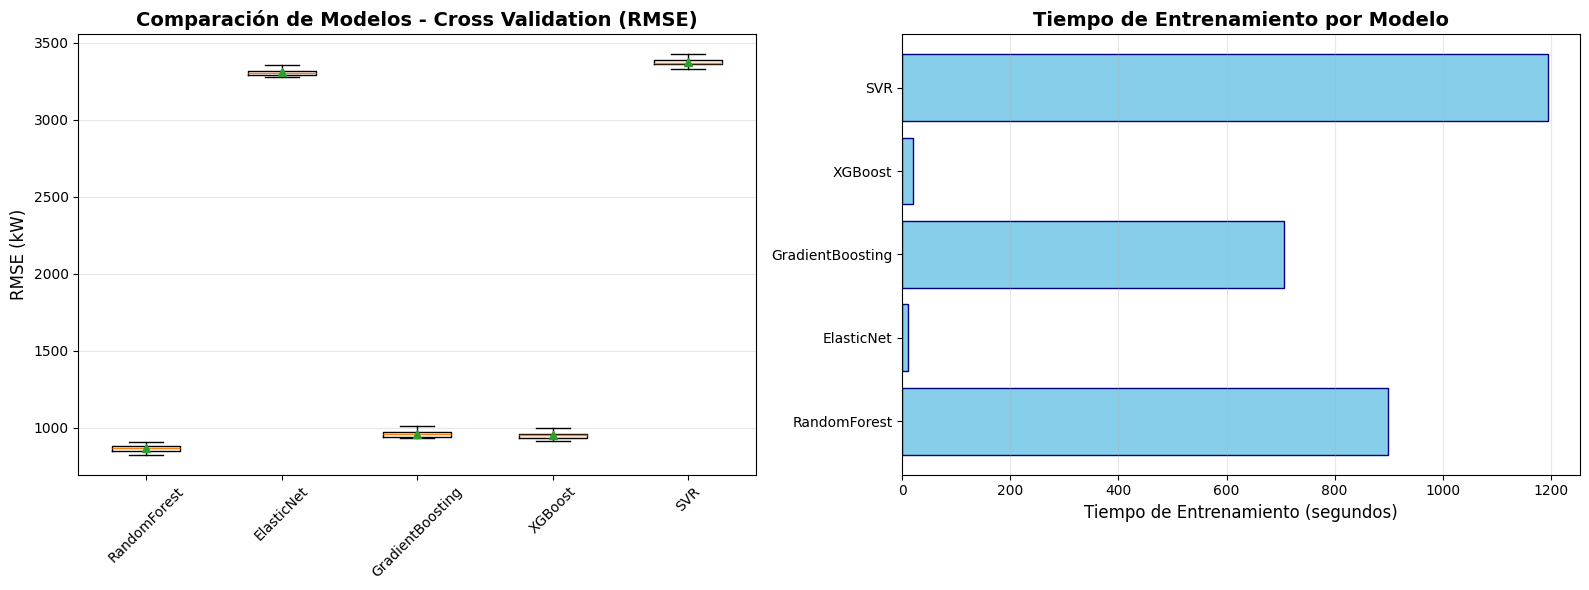

In [46]:
# Visualización de resultados Cross-Validation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot de RMSE
axes[0].boxplot(resultados_cv, labels=nombres, showmeans=True)
axes[0].set_ylabel("RMSE (kW)", fontsize=12)
axes[0].set_title("Comparación de Modelos - Cross Validation (RMSE)", fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico de barras de tiempo de entrenamiento
axes[1].barh(nombres, tiempos_entrenamiento, color='skyblue', edgecolor='navy')
axes[1].set_xlabel("Tiempo de Entrenamiento (segundos)", fontsize=12)
axes[1].set_title("Tiempo de Entrenamiento por Modelo", fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 5.2 Evaluación en Test Set

Ahora entrenaremos todos los modelos con el conjunto completo de entrenamiento y evaluaremos su desempeño en el conjunto de prueba.

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Preparar datos transformados
X_train_transformed = columnasTransformer.fit_transform(x_train)
X_test_transformed = columnasTransformer.transform(x_test)
y_train_flat = np.ravel(y_train)
y_test_flat = np.ravel(y_test)

# Almacenar resultados
resultados_test = []
modelos_entrenados = []

print("="*90)
print("EVALUACIÓN EN TEST SET")
print("="*90)
print(f"{'Modelo':<20} {'RMSE':>12} {'MAE':>12} {'MAPE':>10} {'R²':>8} {'Tiempo':>10}")
print("="*90)

for i in range(len(modelos)):
    # Entrenar modelo
    inicio = time.time()
    modelo = modelos[i]
    modelo.fit(X_train_transformed, y_train_flat)
    tiempo_fit = time.time() - inicio

    # Predecir
    y_pred = modelo.predict(X_test_transformed)

    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred))
    mae = mean_absolute_error(y_test_flat, y_pred)
    mape = mean_absolute_percentage_error(y_test_flat, y_pred) * 100
    r2 = r2_score(y_test_flat, y_pred)

    resultados_test.append({
        'modelo': nombres[i],
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'tiempo': tiempo_fit
    })

    modelos_entrenados.append(modelo)

    print(f"{nombres[i]:<20} {rmse:>12,.2f} {mae:>12,.2f} {mape:>9,.2f}% {r2:>8,.4f} {tiempo_fit:>9,.2f}s")

print("="*90)

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados_test)
df_resultados = df_resultados.sort_values('rmse')
print("\n Ranking de Modelos (ordenado por RMSE):")
print(df_resultados.to_string(index=False))

EVALUACIÓN EN TEST SET
Modelo                       RMSE          MAE       MAPE       R²     Tiempo
RandomForest             3,735.69     2,901.94     11.25%   0.5309     77.77s
ElasticNet               3,644.75     2,835.48     11.80%   0.5535      1.50s
GradientBoosting         3,098.20     2,416.63      9.60%   0.6773     73.76s
XGBoost                  3,090.74     2,423.33      9.66%   0.6789      2.23s
SVR                      8,387.98     6,966.26     27.30%  -1.3650    105.97s

 Ranking de Modelos (ordenado por RMSE):
          modelo        rmse         mae      mape        r2     tiempo
         XGBoost 3090.735912 2423.328924  9.657551  0.678902   2.225302
GradientBoosting 3098.204859 2416.629764  9.598170  0.677348  73.757320
      ElasticNet 3644.751619 2835.481249 11.795949  0.553471   1.500402
    RandomForest 3735.687067 2901.938748 11.249791  0.530912  77.768069
             SVR 8387.977479 6966.258685 27.298023 -1.364983 105.972822


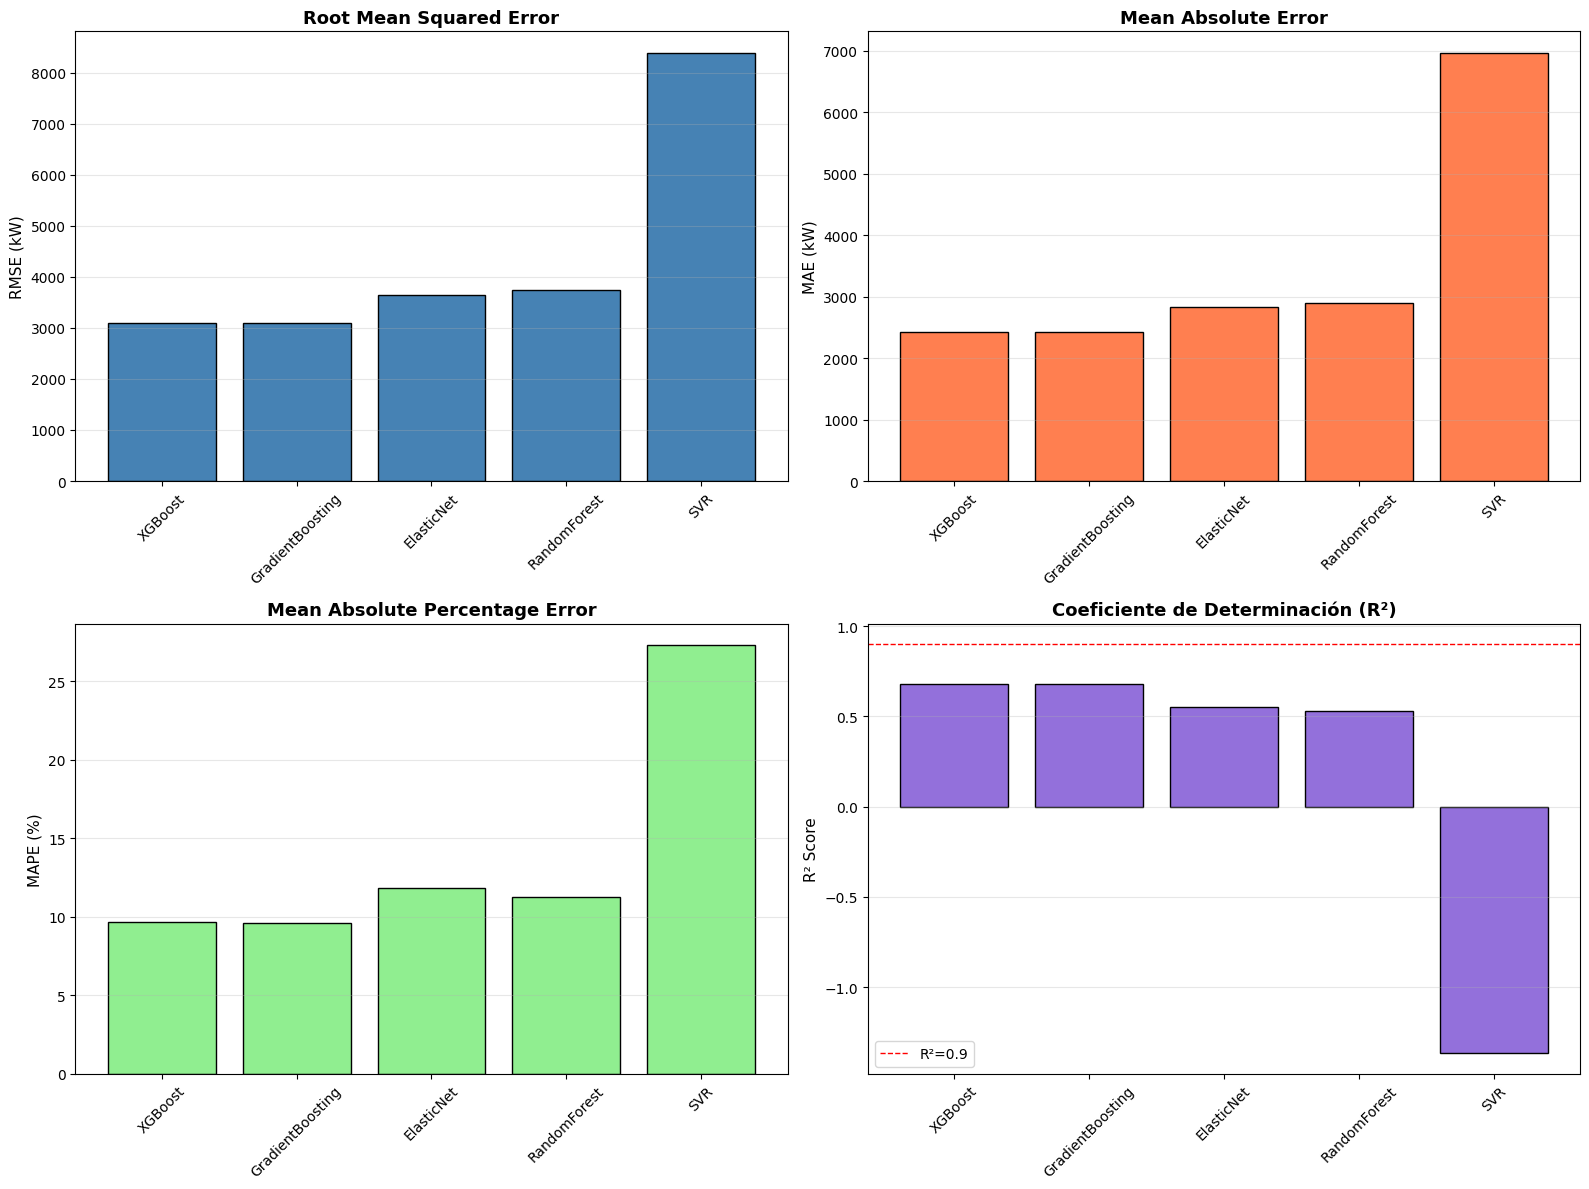

In [49]:
# Visualización comparativa de métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE
axes[0, 0].bar(df_resultados['modelo'], df_resultados['rmse'], color='steelblue', edgecolor='black')
axes[0, 0].set_ylabel('RMSE (kW)', fontsize=11)
axes[0, 0].set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# MAE
axes[0, 1].bar(df_resultados['modelo'], df_resultados['mae'], color='coral', edgecolor='black')
axes[0, 1].set_ylabel('MAE (kW)', fontsize=11)
axes[0, 1].set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# MAPE
axes[1, 0].bar(df_resultados['modelo'], df_resultados['mape'], color='lightgreen', edgecolor='black')
axes[1, 0].set_ylabel('MAPE (%)', fontsize=11)
axes[1, 0].set_title('Mean Absolute Percentage Error', fontsize=13, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# R²
axes[1, 1].bar(df_resultados['modelo'], df_resultados['r2'], color='mediumpurple', edgecolor='black')
axes[1, 1].set_ylabel('R² Score', fontsize=11)
axes[1, 1].set_title('Coeficiente de Determinación (R²)', fontsize=13, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0.9, color='red', linestyle='--', linewidth=1, label='R²=0.9')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5.3 Análisis del Mejor Modelo

Identificaremos el mejor modelo basándose en las métricas de evaluación y generaremos predicciones detalladas.

MEJOR MODELO: XGBoost
RMSE:  3,090.74 kW
MAE:   2,423.33 kW
MAPE:  9.658%
R²:    0.678902


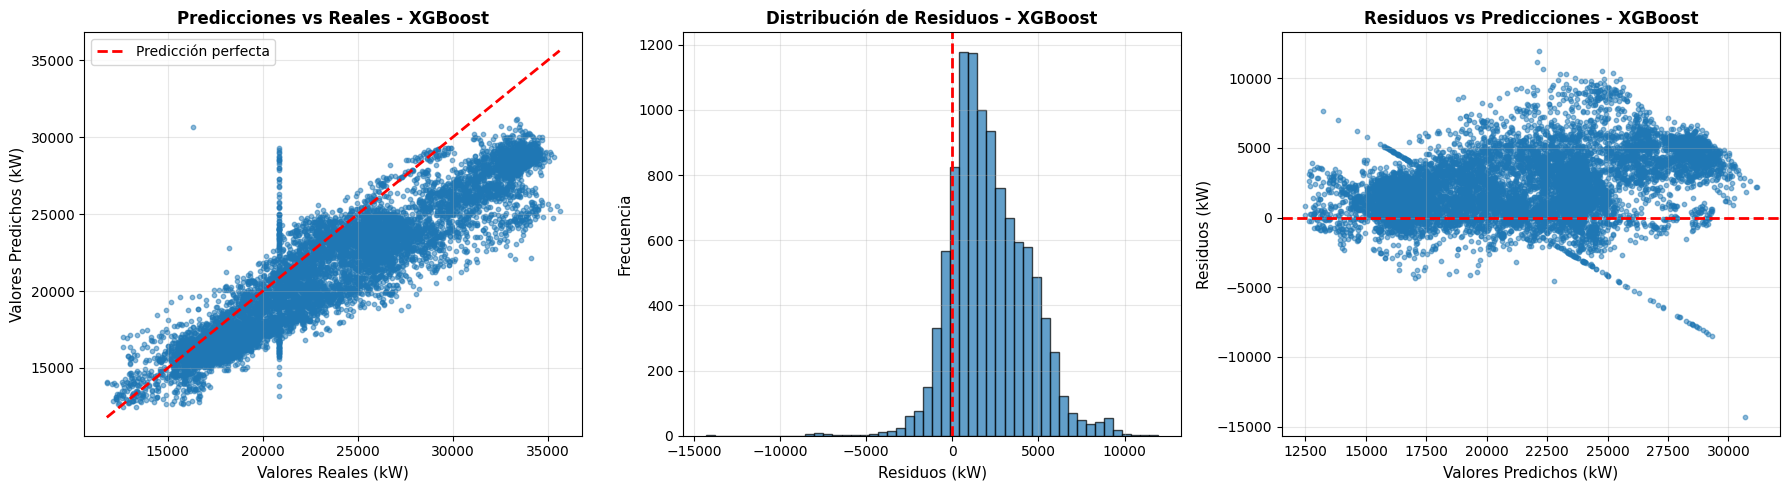


Estadísticas de Residuos:
Media:      2,159.85 kW
Desv. Std:  2,210.82 kW
Min:        -14,331.50 kW
Max:        11,971.17 kW


In [52]:
# Identificar mejor modelo
mejor_idx = df_resultados['rmse'].idxmin()
mejor_modelo_nombre = df_resultados.loc[mejor_idx, 'modelo']
mejor_modelo_obj = modelos_entrenados[nombres.index(mejor_modelo_nombre)]

print("="*70)
print(f"MEJOR MODELO: {mejor_modelo_nombre}")
print("="*70)
print(f"RMSE:  {df_resultados.loc[mejor_idx, 'rmse']:,.2f} kW")
print(f"MAE:   {df_resultados.loc[mejor_idx, 'mae']:,.2f} kW")
print(f"MAPE:  {df_resultados.loc[mejor_idx, 'mape']:.3f}%")
print(f"R²:    {df_resultados.loc[mejor_idx, 'r2']:.6f}")
print("="*70)

# Generar predicciones con el mejor modelo
y_pred_mejor = mejor_modelo_obj.predict(X_test_transformed)

# Análisis de residuos
residuos = y_test_flat - y_pred_mejor

# Visualización del mejor modelo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Predicciones vs Reales
axes[0].scatter(y_test_flat, y_pred_mejor, alpha=0.5, s=10)
axes[0].plot([y_test_flat.min(), y_test_flat.max()],
             [y_test_flat.min(), y_test_flat.max()],
             'r--', lw=2, label='Predicción perfecta')
axes[0].set_xlabel('Valores Reales (kW)', fontsize=11)
axes[0].set_ylabel('Valores Predichos (kW)', fontsize=11)
axes[0].set_title(f'Predicciones vs Reales - {mejor_modelo_nombre}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Distribución de Residuos
axes[1].hist(residuos, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuos (kW)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title(f'Distribución de Residuos - {mejor_modelo_nombre}', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# 3. Residuos vs Predicciones
axes[2].scatter(y_pred_mejor, residuos, alpha=0.5, s=10)
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Valores Predichos (kW)', fontsize=11)
axes[2].set_ylabel('Residuos (kW)', fontsize=11)
axes[2].set_title(f'Residuos vs Predicciones - {mejor_modelo_nombre}', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print("\nEstadísticas de Residuos:")
print(f"Media:      {residuos.mean():,.2f} kW")
print(f"Desv. Std:  {residuos.std():,.2f} kW")
print(f"Min:        {residuos.min():,.2f} kW")
print(f"Max:        {residuos.max():,.2f} kW")

# 6. Guía de Reproducibilidad

Esta sección contiene instrucciones detalladas para reproducir completamente este análisis y los resultados obtenidos.

## 6.1 Requisitos del Sistema

### Software Requerido
- **Python**: 3.8 o superior
- **Jupyter Notebook**: 6.0 o superior (o JupyterLab)
- **Git**: Para control de versiones
- **DVC** (opcional): Para versionamiento de datos

### Especificaciones Recomendadas de Hardware
- **RAM**: Mínimo 8GB, recomendado 16GB
- **Procesador**: Multi-core (4+ cores recomendado)
- **Espacio en disco**: Mínimo 500MB libres

## 6.2 Instalación de Dependencias

### Opción 1: Usando pip (recomendado)
```bash
# Crear entorno virtual
python -m venv venv

# Activar entorno virtual
# En Windows:
venv\Scripts\activate
# En macOS/Linux:
source venv/bin/activate

# Instalar dependencias
pip install pandas numpy matplotlib seaborn scipy scikit-learn xgboost jupyter
o pip install -r requirements.txt
```

### Opción 2: Usando conda
```bash
# Crear entorno conda
conda create -n mlops python=3.10

# Activar entorno
conda activate mlops

# Instalar dependencias
conda install pandas numpy matplotlib seaborn scipy scikit-learn jupyter
pip install xgboost
```

### Versiones de Paquetes Utilizadas
```
pandas>=1.5.0
numpy>=1.23.0
matplotlib>=3.6.0
seaborn>=0.12.0
scipy>=1.9.0
scikit-learn>=1.2.0
xgboost>=1.7.0
jupyter>=1.0.0
```

## 6.3 Estructura del Proyecto

```
MNA_MLOps/
│
├── data/
│   ├── raw/                                    # Datos originales (no modificar)
│   │   ├── power_tetouan_city_original.csv
│   │   └── power_tetouan_city_modified.csv
│   └── processed/                              # Datos procesados
│       └── power_tetouan_city_processed.csv
│
├── notebooks/
│   └── Fase 1_Equipo43.ipynb                  # Este notebook
│
├── docs/
│   └── ML_Canvas.md                           # Machine Learning Canvas
│
├── .gitignore
└── README.md
```

## 6.4 Pasos para Reproducir el Análisis

### Paso 1: Clonar o descargar el proyecto
```bash
git clone https://github.com/oscargarciatec/MNA_MLOps
cd MNA_MLOps
```

### Paso 2: Preparar los datos
1. Descargar el dataset original desde: https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city
2. Colocar los archivos CSV en `data/raw/`
3. Asegurarse de que los nombres de archivo coincidan:
   - `power_tetouan_city_original.csv`
   - `power_tetouan_city_modified.csv`

### Paso 3: Ejecutar el Notebook
1. Abrir Jupyter Notebook:
   ```bash
   jupyter notebook
   ```
2. Navegar a `notebooks/Fase 1_Equipo43.ipynb`
3. Ejecutar todas las celdas en orden: **Cell → Run All**

### Paso 4: Verificar Resultados
- El archivo procesado se guardará automáticamente en `data/processed/`
- Los gráficos se mostrarán inline en el notebook
- Las métricas de evaluación se imprimirán en la salida

## 6.5 Configuración de Reproducibilidad

### Seeds Aleatorias
Para garantizar resultados reproducibles, hemos fijado las siguientes semillas:

```python
# En el código de modelos
random_state=42  # Para todos los modelos de sklearn
np.random.seed(42)  # Para operaciones de numpy
```

### Orden de Ejecución
**IMPORTANTE**: Las celdas deben ejecutarse en orden secuencial. Algunas celdas dependen de variables creadas en celdas anteriores.

### Tiempos de Ejecución Esperados
- **EDA y Preprocesamiento**: ~2-3 minutos
- **Cross-Validation (todos los modelos)**: ~10-15 minutos
- **Entrenamiento final y evaluación**: ~2-3 minutos
- **Total**: ~15-20 minutos (puede variar según hardware)

## 6.6 Solución de Problemas Comunes

### Problema: XGBoost no se instala
**Solución:**
```bash
pip install xgboost
# Si falla, intenta:
conda install -c conda-forge xgboost
```

### Problema: Errores de memoria (MemoryError)
**Soluciones:**
1. Reducir n_estimators en Random Forest y XGBoost
2. Reducir cv.n_repeats en cross-validation
3. Usar un subset de datos para pruebas iniciales

### Problema: FileNotFoundError
**Solución:**
- Verificar que los archivos CSV estén en `data/raw/`
- Verificar que los nombres de archivo sean exactos
- Verificar que estás ejecutando desde el directorio raíz del proyecto

### Problema: Diferentes resultados en diferentes ejecuciones
**Causa**: Las semillas aleatorias no están fijadas correctamente
**Solución**: Verificar que todos los modelos tengan `random_state=42`

## 6.7 Contacto y Soporte

Para preguntas o problemas con la reproducción:
- **Equipo 43**: Ver autores en la sección inicial del notebook
- **Issues**: Crear un issue en el repositorio del proyecto
- **Email**: A01795645@tec.mx

## 6.8 Licencia y Citación

### Dataset
- **Fuente**: UCI Machine Learning Repository
- **Licencia**: CC BY 4.0
- **Citación**: Salam, A., & El Hibaoui, A. (2023). Power Consumption of Tetouan City Dataset. UCI Machine Learning Repository.

### Código
- Proyecto académico - Tecnológico de Monterrey
- Curso: Operaciones de Aprendizaje Automático (MLOps)
- Equipo 43 - Octubre 2025

# 7. Versionamiento de Datos

## 7.1 Estrategia de Versionamiento

Para este proyecto utilizamos un enfoque de versionamiento dual:

1. **Git** - Para código, notebooks y documentación
2. **DVC (Data Version Control)** - Para datasets grandes y modelos entrenados

## 7.2 Archivos Versionados

### Con Git
- ✅ Notebooks (`.ipynb`)
- ✅ Scripts Python (`.py`)
- ✅ Documentación (`.md`)
- ✅ Archivos de configuración

### Con DVC
- ✅ Datasets crudos (`data/raw/*.csv`)
- ✅ Datasets procesados (`data/processed/*.csv`)
- ✅ Modelos entrenados (`.pkl`, `.joblib`)

## 7.3 Dataset Procesado Generado

En este notebook se generó el siguiente archivo procesado:

```python
# Ubicación del archivo
ruta_guardado = "../data/processed/power_tetouan_city_processed.csv"
```

**Características del dataset procesado:**
- **Registros**: 52,418 (después de limpieza)
- **Features**: 15 (8 originales + 7 temporales derivadas)
- **Transformaciones aplicadas**:
  - Eliminación de valores duplicados
  - Tratamiento de outliers (IQR method)
  - Imputación de valores faltantes (mediana)
  - Feature engineering temporal
  - Normalización MinMaxScaler (rango 1-2)

## 7.4 Comandos de Versionamiento

### Versionar dataset con DVC (después de ejecutar este notebook)

```bash
# 1. Agregar dataset procesado a DVC
dvc add data/processed/power_tetouan_city_processed.csv

# 2. Commit el archivo .dvc a Git
git add data/processed/power_tetouan_city_processed.csv.dvc
git commit -m "[data] Add processed dataset v1.0 - IQR outlier treatment + temporal features"

# 3. Push datos a DVC remote storage
dvc push

# 4. Push commits a GitHub
git push origin main
```

### Recuperar dataset (para nuevos miembros del equipo)

```bash
# Después de clonar el repositorio
git clone https://github.com/oscargarciatec/MNA_MLOps
cd MNA_MLOps

# Descargar datos versionados
dvc pull
```

## 7.5 Documentación Completa

Para información detallada sobre el proceso de versionamiento, consultar:

📄 **`docs/Data_Versioning.md`**

Este documento incluye:
- Configuración paso a paso de DVC
- Mejores prácticas de versionamiento
- Workflow completo
- Troubleshooting común
- Convenciones de nomenclatura

## 7.6 Historial de Versiones del Dataset

| Versión | Fecha | Descripción | Registros | Features |
|---------|-------|-------------|-----------|----------|
| v1.0 | 2025-10-09 | Dataset inicial procesado | 52,418 | 15 |

### Cambios v1.0
- ✅ Eliminación de columna `mixed_type_col`
- ✅ Imputación de valores faltantes (mediana)
- ✅ Eliminación de 1,045 timestamps duplicados
- ✅ Tratamiento de outliers con IQR + mediana local
- ✅ Creación de 7 features temporales (Day, Month, Hour, etc.)
- ✅ Normalización con MinMaxScaler (1-2)

---

**Nota**: Este dataset procesado es el utilizado para entrenar y evaluar todos los modelos en la Sección 5.